In [1]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from tqdm import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model, Sequential


In [2]:
#
BUFFER_SIZE = 400
BATCH_SIZE = 256
INPUT_SHAPE = [28, 28, 1]
EPOCHS = 10

In [3]:
data = tfds.load("mnist")


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [4]:
def train_preprocess(img_dict):
  img, label = img_dict['image'], tf.cast(img_dict['label'], tf.float32)
  img = tf.cast(img, tf.float32)
  img = img/127.5 - 1

  label = tf.reshape(label, [-1])

  return img, label


tf.Tensor([4.], shape=(1,), dtype=float32)


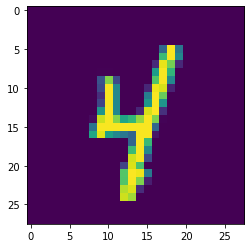

In [5]:

for i in data['train']:
  img, label = train_preprocess(i)
  print(label)
  plt.imshow(img[:, :, 0])
  break

In [6]:
data['train'] = data['train'].map(train_preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
data['test'] = data['test'].map(train_preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
sample_test = next(iter(data['test']))

In [8]:
sample_train = next(iter(data['train']))

tf.Tensor([5.], shape=(1,), dtype=float32)


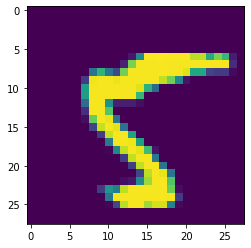

In [9]:
imgs, labels = sample_train
print(labels[0])
plt.imshow(imgs[0][:, :, 0])

In [10]:
def make_model():
  inp = layers.Input(shape=INPUT_SHAPE)

  layer = Sequential()
  layer.add(layers.Conv2D(32, kernel_size=(5,5),strides=(2,2), padding='same', use_bias=False))
  layer.add(layers.BatchNormalization())
  layer.add(layers.LeakyReLU())
  layer.add(layers.ZeroPadding2D())
  layer.add(layers.Conv2D(32, kernel_size=(5,5), strides=(4,4), padding='same', use_bias=False))
  layer.add(layers.BatchNormalization())
  layer.add(layers.LeakyReLU())
  layer.add(layers.Flatten())
  layer.add(layers.Dense(10, activation='sigmoid'))

  x = inp
  x = layer(x)

  return Model(inputs = inp, outputs = x)


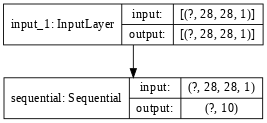

In [11]:
predictor = make_model()
tf.keras.utils.plot_model(predictor, show_shapes=True, dpi=64)

In [12]:
predictor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                31786     
Total params: 31,786
Trainable params: 31,658
Non-trainable params: 128
_________________________________________________________________


In [13]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def calc_loss(y_real, y_pred):
  return cross_entropy(y_real, y_pred)

opt = tf.keras.optimizers.Adam(1e-4)

In [14]:
@tf.function
def train_step(batch):
  img, y_real = batch
  with tf.GradientTape() as tape:
    y_pred = predictor(img, training=True)
    loss = calc_loss(y_real, y_pred)
  
  grad = tape.gradient(loss, predictor.trainable_variables)
  opt.apply_gradients(zip(grad, predictor.trainable_variables))


@tf.function
def test_step(batch):
  img, y_real = batch
  y_pred = predictor(img, training=False)
  return tf.keras.metrics.sparse_categorical_accuracy(y_real, y_pred), tf.cast(img.shape[0],tf.float32)

    

In [15]:
tf.reduce_mean(test_step(sample_test)[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.125>

In [16]:
def train(data, EPOCHS):
  init = time.time()
  acc = 0.0
  total_size = 0.0
  for epoch in range(EPOCHS):
    start = time.time()
    print(f'Training epoch {epoch + 1}')
    for batch in data['train']:
      train_step(batch)
    total_size = 0.0
    acc = 0.0
    for batch in data['test']:
      v, size = test_step(batch)
      acc += tf.reduce_sum(v)
      total_size += size
    print(f' Time taken by epoch {epoch+1} : {time.time()-start}')
    print(f' accuracy : {acc/total_size}')
    print(f' Total time ellapsed so far : {time.time()-init}')
    print(100*'-')
  print("Model trained.")
  print(f' accuracy : {acc/total_size}')
  print(f' Total time ellapsed so far : {time.time()-init}')





In [17]:
train(data, EPOCHS)

Training epoch 1
 Time taken by epoch 1 : 15.539807796478271
 accuracy : 0.8385000228881836
 Total time ellapsed so far : 15.54079270362854
----------------------------------------------------------------------------------------------------
Training epoch 2
 Time taken by epoch 2 : 14.459855794906616
 accuracy : 0.8934000134468079
 Total time ellapsed so far : 30.00198459625244
----------------------------------------------------------------------------------------------------
Training epoch 3
 Time taken by epoch 3 : 14.523184061050415
 accuracy : 0.9178000092506409
 Total time ellapsed so far : 44.52705907821655
----------------------------------------------------------------------------------------------------
Training epoch 4
 Time taken by epoch 4 : 14.374156713485718
 accuracy : 0.932699978351593
 Total time ellapsed so far : 58.90263485908508
----------------------------------------------------------------------------------------------------
Training epoch 5
 Time taken by epoch

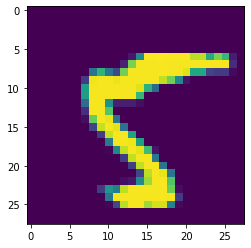

In [33]:
sample_img = tf.stack([imgs[0]], axis=0)
plt.imshow(sample_img[0,:,:,0])

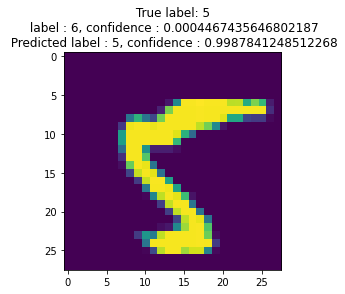

In [86]:
def display(imgs,input_label,true_label):
  prob_vec = predictor(imgs)[0].numpy()
  label = input_label[0].numpy()
  y_pred = tf.argmax(prob_vec).numpy()
  plt.figure()
  plt.title(f' True label: {true_label} \n label : {label}, confidence : {prob_vec[label]}\n Predicted label : {y_pred}, confidence : {prob_vec[y_pred]}')
  plt.imshow(imgs[0,:,:,0])

display(sample_img, input_label,5)

Now lets fool the above model using some basic calculus.

adv_img = img + eps*purturbation

where 
purturbation = sign(gradient(cross_entropy(input_label, predictor(input_image)), input_image))

eps : hyperparamter


In [92]:
predictor.trainable = False
input_label = tf.stack([5], axis=0) # trying to get the model to classify the 5 as 6

In [93]:
def create_adv_img(input_image, input_label, eps):
  true_label = tf.argmax(predictor(input_image)[0]).numpy()
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    y_pred = predictor(input_image, training=False)
    loss = calc_loss(input_label, y_pred)
  
  grad = tape.gradient(loss, input_image)
  sign = tf.sign(grad)

  new_img = input_image + eps*sign

  return new_img, true_label


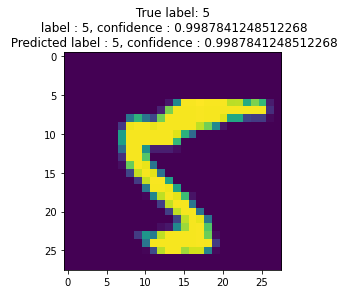

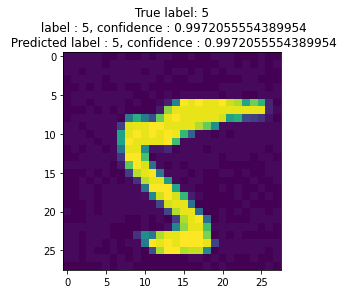

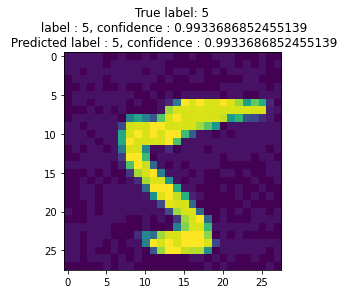

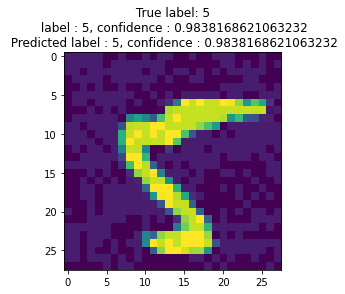

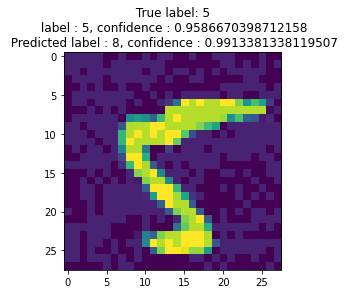

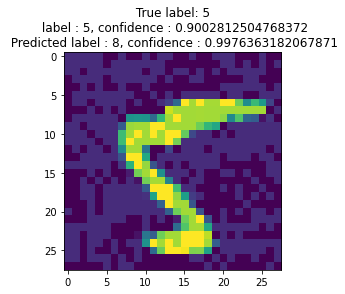

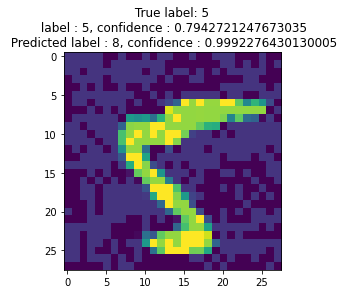

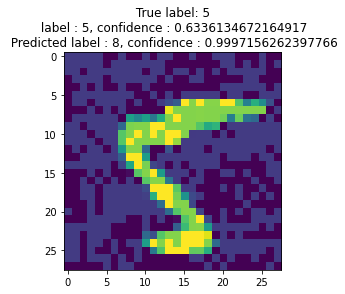

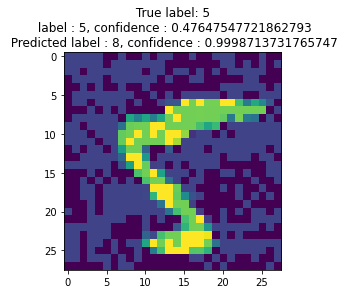

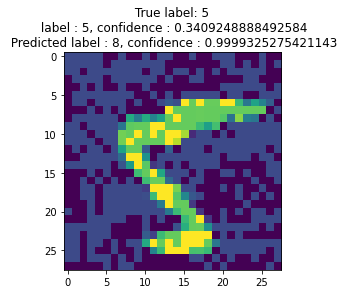

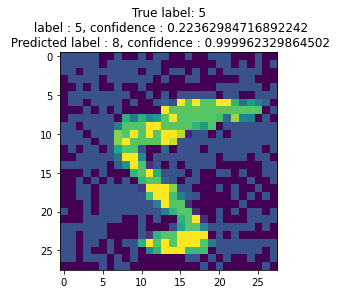

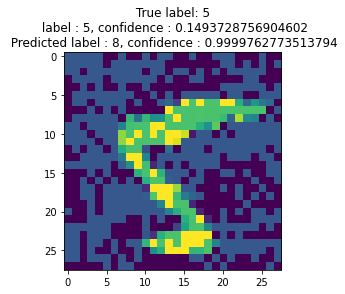

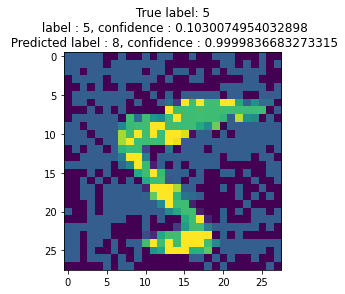

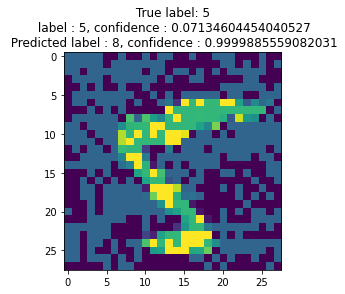

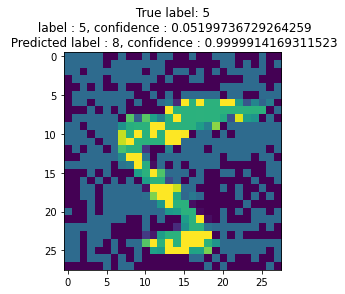

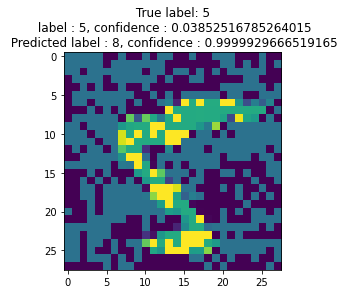

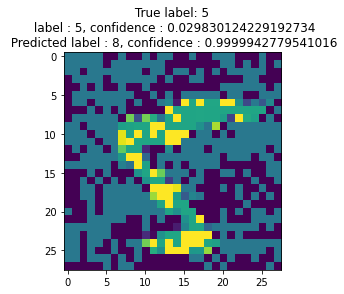

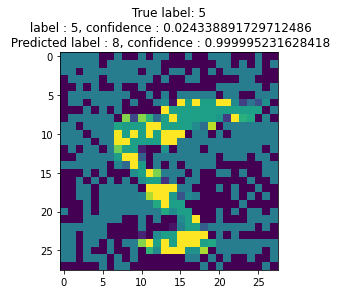

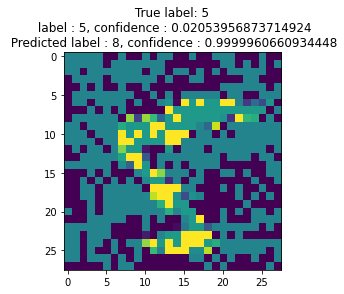

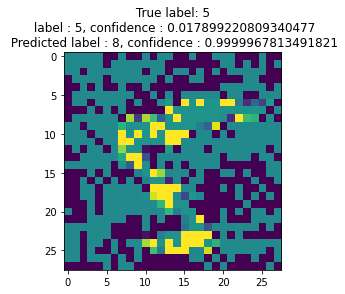

In [94]:
eps = 0.
while eps < 1:
  adv_img, true_label = create_adv_img(sample_img, input_label, eps)
  adv_img = tf.clip_by_value(adv_img, -1, 1)
  display(adv_img, input_label,true_label)
  eps+= 0.05


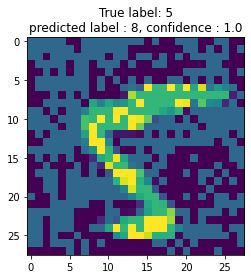